In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray as rxr
import metloom
import matplotlib.pyplot as plt
import pandas as pd 
import geopandas as gpd
from metloom.pointdata import CDECPointData, SnotelPointData
from metloom.variables import CdecStationVariables, SnotelVariables
import datetime
import glob
import rioxarray as rxt

plt.style.use('/Users/cowherd/Documents/mplstyles/marianne.mplstyle')

In [2]:
caldor = gpd.read_file('../data/caldor.shp')
caldor = caldor.to_crs('EPSG:4326')
tahoe = gpd.read_file('../data/lake-tahoe.geojson')

In [3]:
modis = xr.open_dataset('/Users/cowherd/DATA/modis/caldormodis.nc')

In [88]:
da = modis.Snow_Cover_Monthly_CMG
## standardized variate ## 
stds = []
for time in da.time:
    tmp = da.sel(time = time)
    tmp = tmp.where(tmp <=100)
    tmp[10, 28] = np.nan
    tmp[6:9, 27] = np.nan
    tmp[6, 28] = np.nan
    tmp[5, 28:31] = np.nan
    newvals = (tmp - np.nanmean(tmp)) / np.nanstd(tmp)
    stds.append(newvals)
    
stdv = xr.concat(stds, dim ='time')

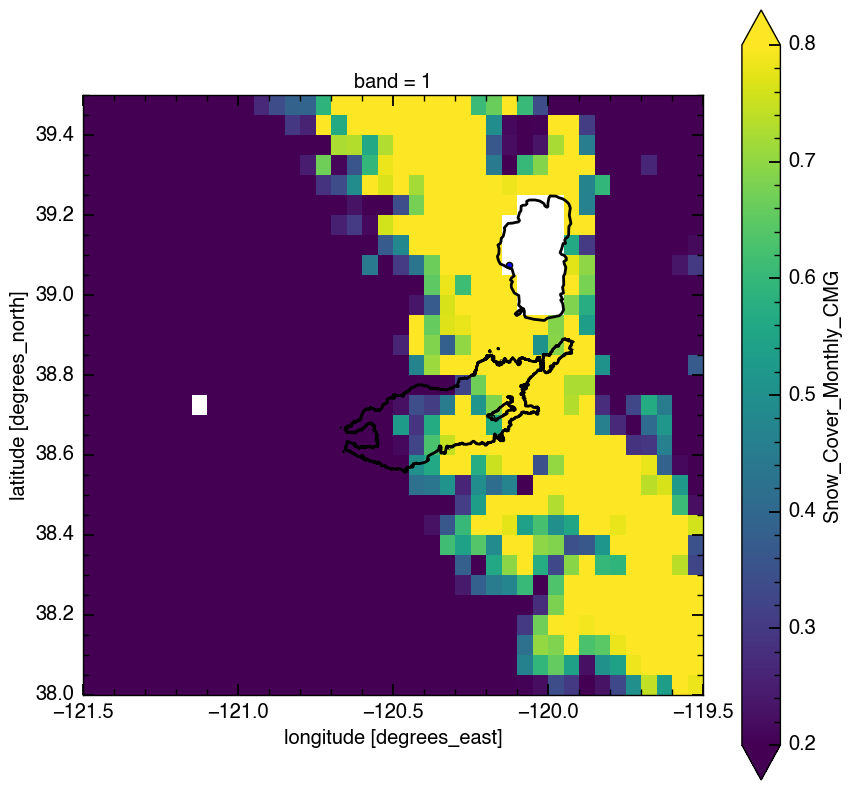

In [89]:
fig, ax = plt.subplots(figsize=(10, 10))
stdv.mean(dim='time').plot(ax=ax, cmap='viridis', vmin=0.2, vmax=0.8)
caldor.boundary.plot(ax=ax, edgecolor='black', linewidth=2)
tahoe.boundary.plot(ax=ax, edgecolor='black', linewidth=2)
ax.scatter([stdv.x[27]], [stdv.y[8]])
plt.show()

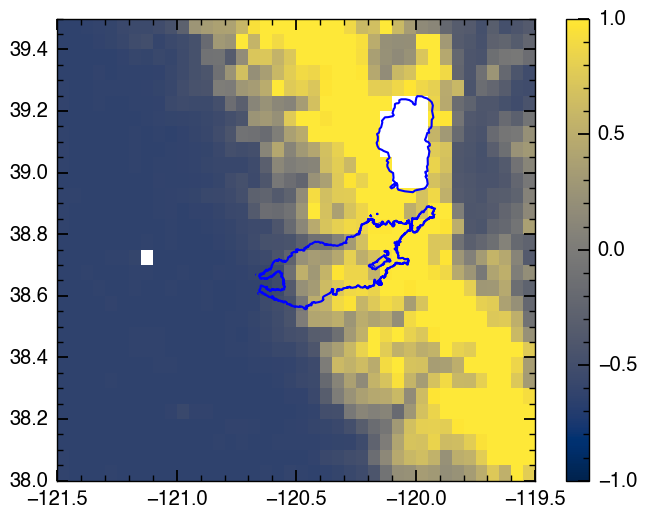

/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


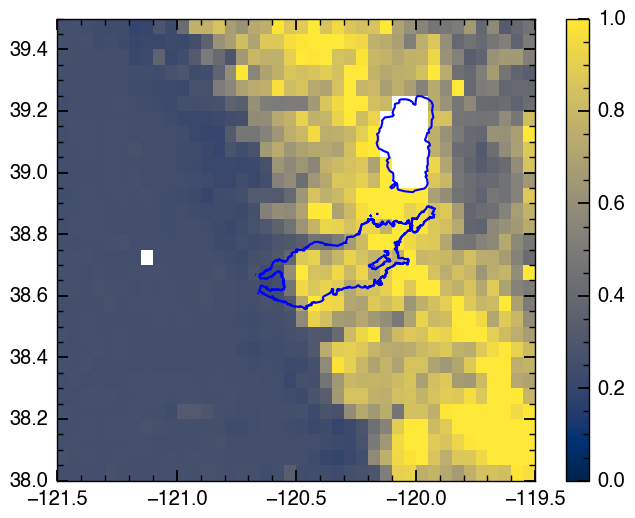

In [90]:
## MEAN
fig, ax = plt.subplots()
cb = ax.pcolormesh(stdv.x, stdv.y, stdv.mean(dim = 'time'), vmin = -1, vmax =1)
plt.colorbar(cb, ax=ax)
caldor.boundary.plot(ax = ax)
tahoe.boundary.plot(ax = ax)
plt.show()

## STD
fig, ax = plt.subplots()
cb = ax.pcolormesh(stdv.x, stdv.y, stdv.std(dim = 'time'), vmin = 0, vmax =1)
caldor.boundary.plot(ax = ax)
tahoe.boundary.plot(ax = ax)
plt.colorbar(cb, ax=ax)
plt.show()

14 2019


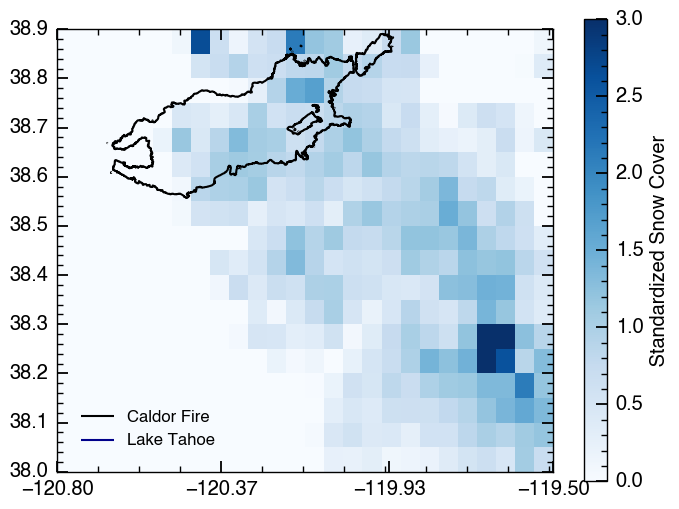

14 2020


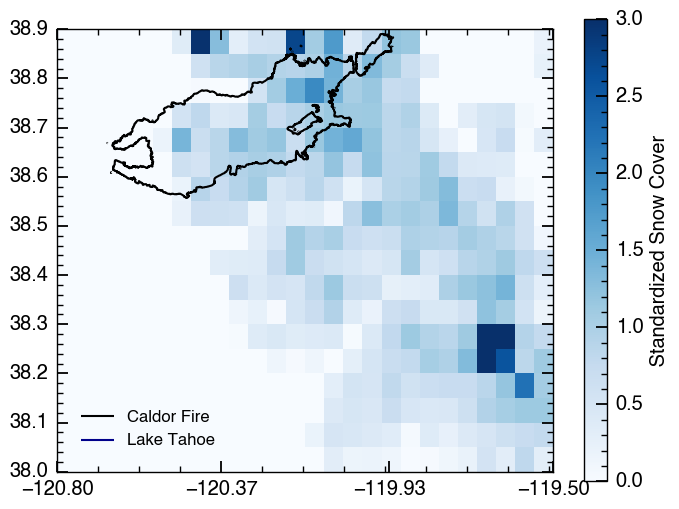

14 2021


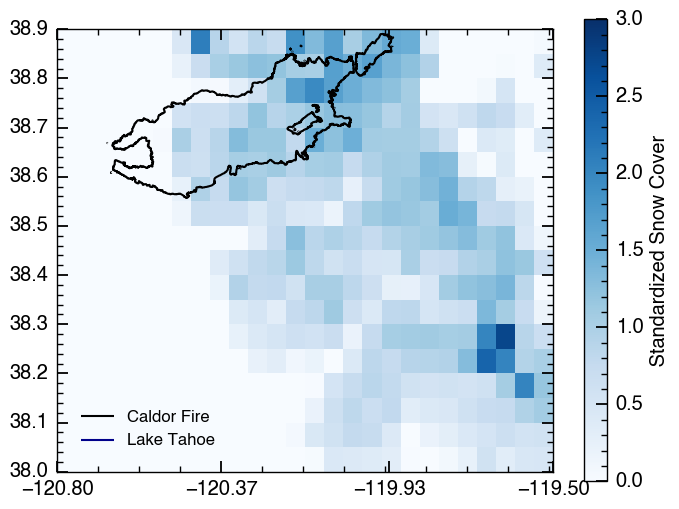

13 2022


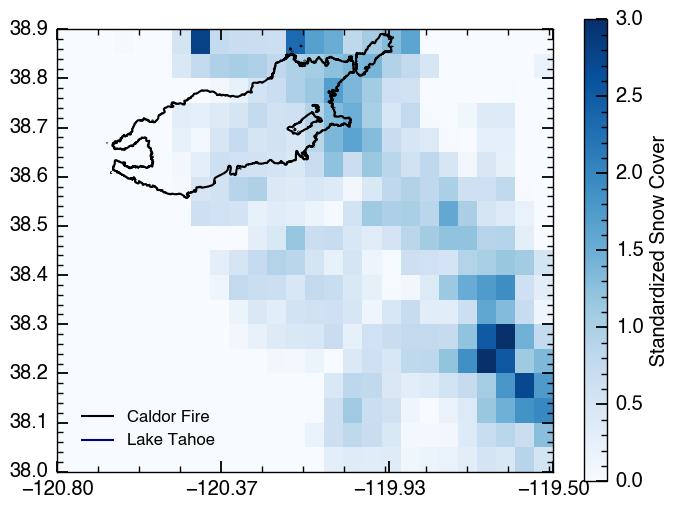

14 2023


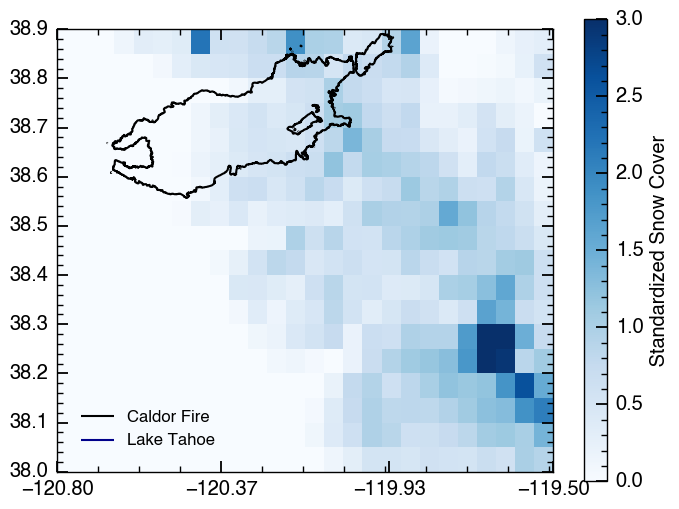

7 2024


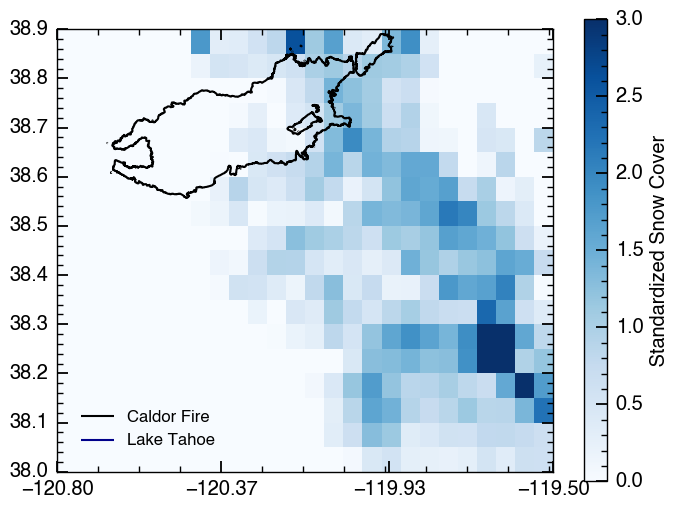

0 2025


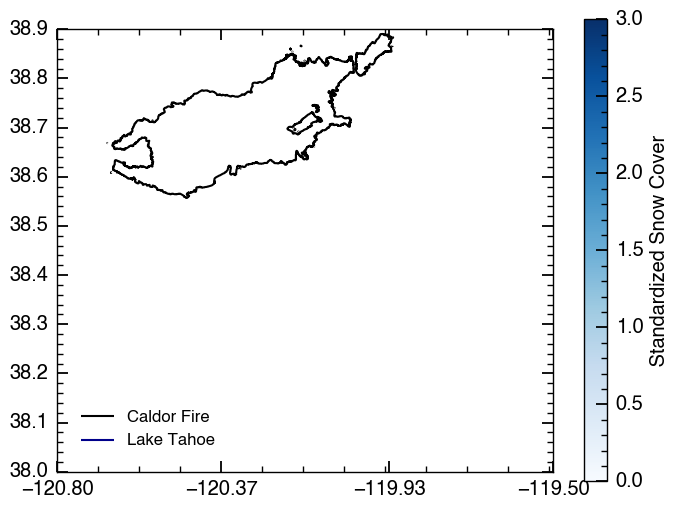

In [91]:
for yr in [2018,2019,2020,2021,2022,2023,2024]:
    mystdv = stdv.sel(time = slice(datetime.date(yr,8,1),datetime.date(yr+1,9,30)))
    print(len(mystdv), yr+1)
    fig, ax = plt.subplots()
    cb = ax.pcolormesh(stdv.x, stdv.y, mystdv.mean(dim = 'time'), cmap = 'Blues' , vmin = 0, vmax = 3)
    plt.colorbar(cb, ax=ax, label = ' Standardized Snow Cover ')
    caldor.boundary.plot(ax = ax, color = 'black', label = 'Caldor Fire')
    tahoe.boundary.plot(ax = ax, color = 'darkblue', label = 'Lake Tahoe')
    ax.set_xlim((-120.8,-119.5))
    ax.set_ylim((38.0,38.9))
    ax.legend(loc = 'lower left')
    ax.set_xticks([round(v, 2) for v in np.linspace(-120.8,-119.5, 4)])
    plt.show()

post-pre: negative values indicate a decrease in snow cover


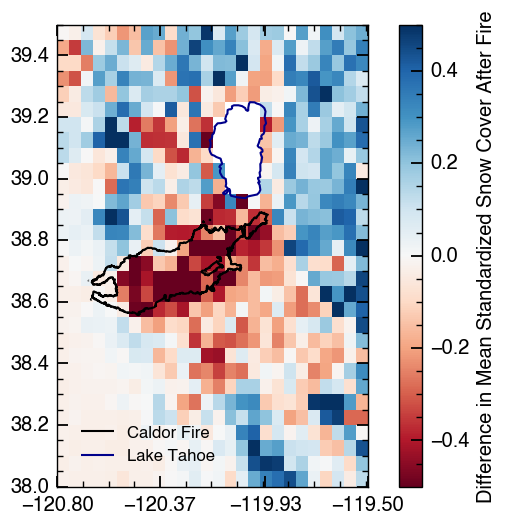

/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


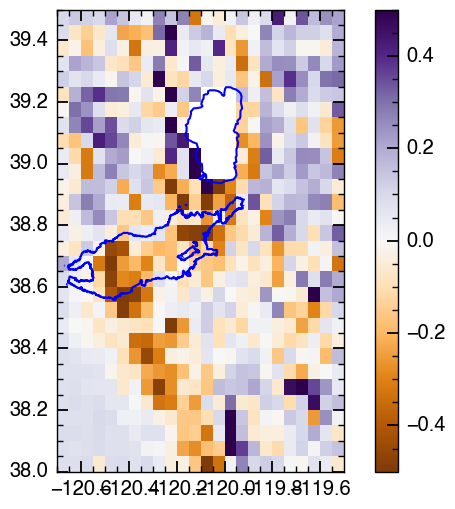

In [92]:
## PREFIRE
## post - pre:
print('post-pre: negative values indicate a decrease in snow cover')
import datetime
stdv_pre = stdv.sel(time = slice(datetime.date(2018,1,1),datetime.date(2021,9,1)))
stdv_post = stdv.sel(time = slice(datetime.date(2022,8,1),datetime.date(2023,10,1)))
fig, ax = plt.subplots()
cb = ax.pcolormesh(stdv.x, stdv.y, stdv_post.mean(dim = 'time') - stdv_pre.mean(dim = 'time') , vmin = -0.5, vmax =.5, cmap = 'RdBu')
plt.colorbar(cb, ax=ax, label = 'Difference in Mean Standardized Snow Cover After Fire')
caldor.boundary.plot(ax = ax, color = 'black', label = 'Caldor Fire')
tahoe.boundary.plot(ax = ax, color = 'darkblue', label = 'Lake Tahoe')
ax.set_xlim((-120.8,-119.5))
ax.legend(loc = 'lower left')
ax.set_xticks([round(v, 2) for v in np.linspace(-120.8,-119.5, 4)])
plt.show()

## post - pre:
stdv_pre = stdv.sel(time = slice(datetime.date(2018,1,1),datetime.date(2021,9,1)))
stdv_post = stdv.sel(time = slice(datetime.date(2022,8,1),datetime.date(2023,10,1)))
fig, ax = plt.subplots()
cb = ax.pcolormesh(stdv.x, stdv.y, stdv_post.std(dim = 'time') - stdv_pre.std(dim = 'time') , vmin = -0.5, vmax =.5, cmap = 'PuOr')
plt.colorbar(cb, ax=ax)
caldor.boundary.plot(ax = ax)
tahoe.boundary.plot(ax = ax)
ax.set_xlim((-120.7,-119.5))
plt.show()

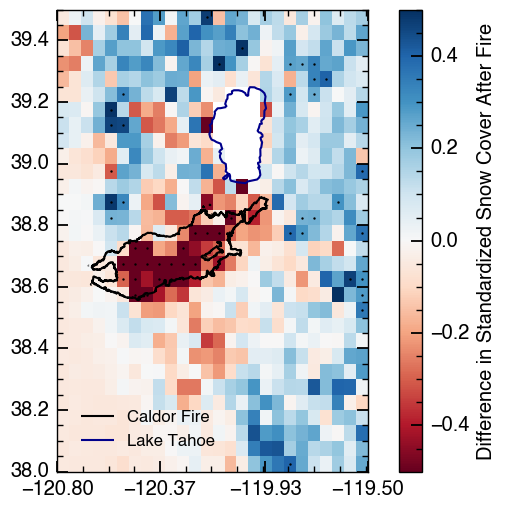

In [95]:
from scipy.stats import ttest_ind

stdv_pre = stdv.sel(time = slice(datetime.date(2018,1,1),datetime.date(2021,9,1)))
stdv_post = stdv.sel(time = slice(datetime.date(2022,8,1),datetime.date(2024,10,1)))

t_stat, p_val = ttest_ind(stdv_pre.values, stdv_post.values, axis=0)

# use 0.05 as the p value threshold 
sig_mask = p_val < 0.05

# diff in standardized snow cover. post - pre. positive = postfire increase
fig, ax = plt.subplots()
cb = ax.pcolormesh(stdv.x, stdv.y, stdv_post.mean(dim = 'time') - stdv_pre.mean(dim = 'time') , vmin = -0.5, vmax =.5, cmap = 'RdBu')
plt.colorbar(cb, ax=ax, label = 'Difference in Standardized Snow Cover After Fire')


# Add stippling for statistically significant changes
# cbar2 = ax.pcolor(stdv.x, stdv.y, sig_mask, hatch = '...', cmap = None)
x_grid, y_grid = np.meshgrid(stdv.x.values, stdv.y.values)
ax.scatter(x_grid[sig_mask], y_grid[sig_mask], marker='.', color='black', s=2)

caldor.boundary.plot(ax = ax, color = 'black', label = 'Caldor Fire')
tahoe.boundary.plot(ax = ax, color = 'darkblue', label = 'Lake Tahoe')
ax.set_xlim((-120.8,-119.5))
ax.legend(loc = 'lower left')
ax.set_xticks([round(v, 2) for v in np.linspace(-120.8,-119.5, 4)])
plt.savefig('../figures/modis_diff.jpg', dpi = 500)
plt.show()